# 2.4 Treino de modelos clássicos

In [4]:
#Importação de blibliotecas
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
import re


In [2]:
#Importação de dados de treino e teste
train_df = pd.read_csv('amazon_reviews_train.csv')
test_df = pd.read_csv('amazon_reviews_test.csv')

Definição das funções de pré-processamento que deram os melhores resultados

In [6]:
#Remoção das tags HTML encontradas nos datasets
def remove_specific_html_tags(text):
    text = text.replace('<br />', '\n')
    text = re.sub(r'<a[^>]*>', '', text)
    text = text.replace('</a>', '')
    text = re.sub(r'<span[^>]*>', '', text)
    text = text.replace('</span>', '')
    text = text.replace('<p>', '').replace('</p>', '')

    return text

#Substituição de alguns emoticons encontrados no texto por palavras que representam o sentimento deles
def replace_emojis(text):
    
    emoji_dict = {
        ':)': 'good',
        ':-)': 'good',
        ':-D': 'good',
        ':D': 'good',
        ':(': 'bad',
        ':-(': 'bad',
        ':O': 'surprised',
    }
    for emoji, emotion in emoji_dict.items():
        text = text.replace(emoji, emotion)

    return text

# Expressão regular para encontrar caracteres estranhos
padrao = re.compile(r"[^a-zA-Z0-9\s.,;:!?\"'()\[\]{}@#%&/\-_=+<>€$£]")
def remover_caracteres_estranhos(text):
    return padrao.sub('', str(text))


# Função para remover espaços em branco múltiplos e substituir por um único espaço
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()


#Função para adicionar o prefixo "NOT_" a palavras que seguem uma negação e para de adicionar quando encontra pontuação ou certas conjunções
def handle_negations_with_not(text):
    negation_words = {"not", "no", "never", "n't"}
    tokens = word_tokenize(text)
    processed_tokens = []
    negate = False

    for token in tokens:
        if token.lower() in negation_words:
            negate = True
            processed_tokens.append(token)
        elif negate:
            if token in {".", ",", "!", "?", ",",";", "but","however","although","even though","despite","in spite of"}:
                negate = False
            processed_tokens.append(f"NOT_{token}" if negate else token)
        else:
            processed_tokens.append(token)
    return ' '.join(processed_tokens)


#Função para aplicar stemming
def apply_stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)





Implementação do pré-processamento no conjunto de treino e teste

In [7]:
def preprocess_text(text):
    text = remove_specific_html_tags(text)
    text = replace_emojis(text)
    text = remover_caracteres_estranhos(text)
    text = remove_multiple_spaces(text)
    text = handle_negations_with_not(text)
    text = apply_stemming(text)
    return text

train_processed = train_df['review'].apply(preprocess_text)
test_processed = test_df['review'].apply(preprocess_text)


Modelos Clássicos com TF-IDF sem oversampling

=== Naïve Bayes (Original) ===
Acurácia: 0.8229
              precision    recall  f1-score   support

    negative       0.87      0.50      0.63       741
    positive       0.81      0.97      0.88      1676

    accuracy                           0.82      2417
   macro avg       0.84      0.73      0.76      2417
weighted avg       0.83      0.82      0.81      2417


=== Regressão Logística (Original) ===
Acurácia: 0.8540
              precision    recall  f1-score   support

    negative       0.72      0.86      0.78       741
    positive       0.93      0.85      0.89      1676

    accuracy                           0.85      2417
   macro avg       0.83      0.86      0.84      2417
weighted avg       0.87      0.85      0.86      2417


=== SVM (Original) ===
Acurácia: 0.8593
              precision    recall  f1-score   support

    negative       0.74      0.83      0.78       741
    positive       0.92      0.87      0.90      1676

    accuracy                        

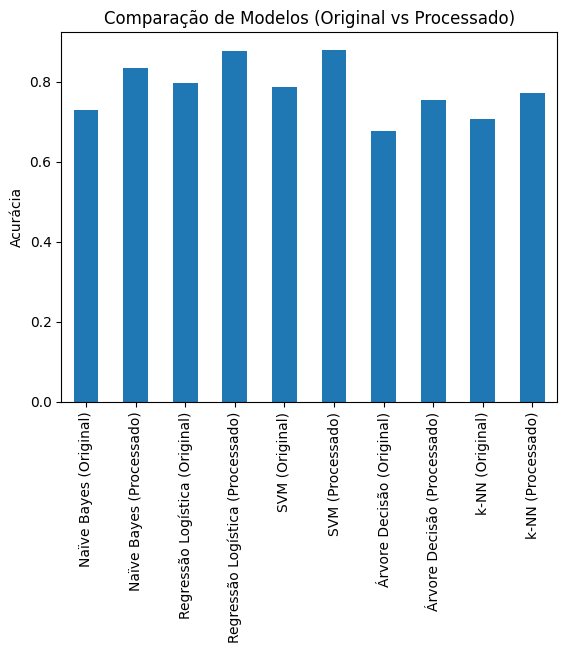

In [8]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')

# Multinomial Naive Bayes
nb_model = Pipeline([
    ('tfidf', vectorizer),
    ('clf', MultinomialNB(alpha=0.1))
])

# Regressão Logística
lr_model = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        C=0.5,
        solver='saga'
    ))
])

# SVM
svm_model = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LinearSVC(
        class_weight='balanced',
        dual=False,
        max_iter=10000,
        C=0.5,
        loss='squared_hinge'
    ))
])

# Árvore de Decisão
dt_model = Pipeline([
    ('tfidf', vectorizer),
    ('clf', DecisionTreeClassifier(
        max_depth=50,
        min_samples_split=20,
        class_weight='balanced',
        random_state=123
    ))
])

# KNN
knn_model = Pipeline([
    ('tfidf', vectorizer),
    ('clf', KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        metric='cosine'
    ))
])

#Treinar os modelos e mostrar relatório de classificação
def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    return model

# Execução para cada modelo com o dataset original
print("=== Naïve Bayes (Original) ===")
nb_trained_original = train_evaluate(nb_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Regressão Logística (Original) ===")
lr_trained_original = train_evaluate(lr_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== SVM (Original) ===")
svm_trained_original = train_evaluate(svm_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Árvore de Decisão (Original) ===")
dt_trained_original = train_evaluate(dt_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== k-NN (Original) ===")
knn_trained_original = train_evaluate(knn_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])

# Execução para cada modelo com o dataset processado
print("\n=== Naïve Bayes (Processado) ===")
nb_trained_processed = train_evaluate(nb_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Regressão Logística (Processado) ===")
lr_trained_processed = train_evaluate(lr_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== SVM (Processado) ===")
svm_trained_processed = train_evaluate(svm_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Árvore de Decisão (Processado) ===")
dt_trained_processed = train_evaluate(dt_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== k-NN (Processado) ===")
knn_trained_processed = train_evaluate(knn_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])

# Análise comparativa
results_TFIDF = {
    'Naïve Bayes (Original)': accuracy_score(test_df['sentiment'], nb_trained_original.predict(test_df['review'])),
    'Naïve Bayes (Processado)': accuracy_score(test_df['sentiment'], nb_trained_processed.predict(test_processed)),
    'Regressão Logística (Original)': accuracy_score(test_df['sentiment'], lr_trained_original.predict(test_df['review'])),
    'Regressão Logística (Processado)': accuracy_score(test_df['sentiment'], lr_trained_processed.predict(test_processed)),
    'SVM (Original)': accuracy_score(test_df['sentiment'], svm_trained_original.predict(test_df['review'])),
    'SVM (Processado)': accuracy_score(test_df['sentiment'], svm_trained_processed.predict(test_processed)),
    'Árvore Decisão (Original)': accuracy_score(test_df['sentiment'], dt_trained_original.predict(test_df['review'])),
    'Árvore Decisão (Processado)': accuracy_score(test_df['sentiment'], dt_trained_processed.predict(test_processed)),
    'k-NN (Original)': accuracy_score(test_df['sentiment'], knn_trained_original.predict(test_df['review'])),
    'k-NN (Processado)': accuracy_score(test_df['sentiment'], knn_trained_processed.predict(test_processed))
}

pd.Series(results_TFIDF).plot(kind='bar', title='Comparação de Modelos (Original vs Processado)')
pd.Series(results_TFIDF).plot(kind='bar', title='Comparação de Modelos (Original vs Processado)')
plt.ylabel('Acurácia')
plt.show()

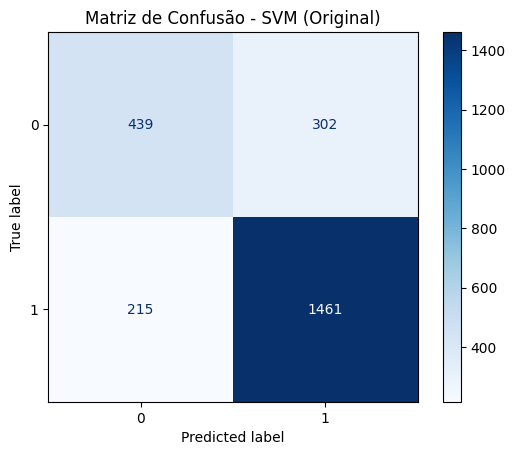

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Previsão com o modelo SVM (dados originais, sem pré-processamento)
y_pred_svm_original = svm_trained_original.predict(test_df['review'])

# Gerar gráfico de matriz de confusão
cm = confusion_matrix(test_df['sentiment'], y_pred_svm_original)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - SVM (Original)')
plt.show()


Modelos Clássicos com TF-IDF com oversampling

=== Naïve Bayes (Original + SMOTE) ===
Acurácia: 0.8527
              precision    recall  f1-score   support

    negative       0.72      0.85      0.78       741
    positive       0.93      0.86      0.89      1676

    accuracy                           0.85      2417
   macro avg       0.82      0.85      0.83      2417
weighted avg       0.86      0.85      0.86      2417


=== Regressão Logística (Original + SMOTE) ===
Acurácia: 0.8631
              precision    recall  f1-score   support

    negative       0.74      0.85      0.79       741
    positive       0.93      0.87      0.90      1676

    accuracy                           0.86      2417
   macro avg       0.84      0.86      0.84      2417
weighted avg       0.87      0.86      0.87      2417


=== SVM (Original + SMOTE) ===
Acurácia: 0.8581
              precision    recall  f1-score   support

    negative       0.75      0.81      0.78       741
    positive       0.91      0.88      0.90      1676

    accuracy

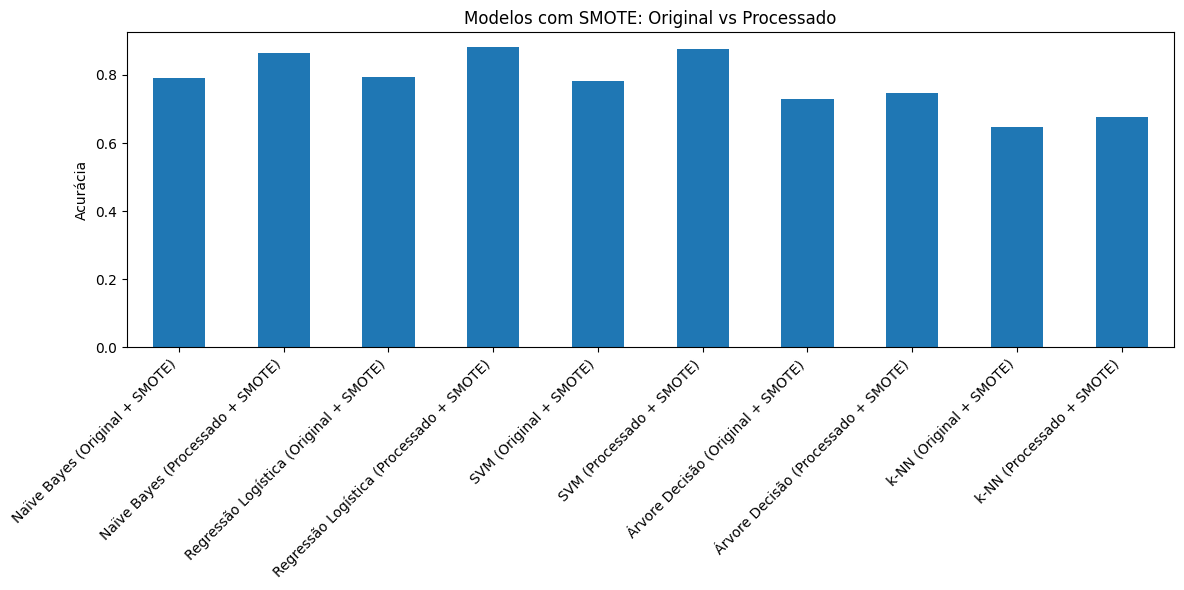

In [11]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')

# Modelos com SMOTE
nb_model = Pipeline([
    ('tfidf', vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', MultinomialNB(alpha=0.1))
])

lr_model = Pipeline([
    ('tfidf', vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, solver='saga'))
])

svm_model = Pipeline([
    ('tfidf', vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=0.5, loss='squared_hinge'))
])

dt_model = Pipeline([
    ('tfidf', vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(max_depth=50, min_samples_split=20, class_weight='balanced', random_state=123))
])

knn_model = Pipeline([
    ('tfidf', vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))
])

def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    return model

#original+smote
print("=== Naïve Bayes (Original + SMOTE) ===")
nb_trained_original = train_evaluate(nb_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Regressão Logística (Original + SMOTE) ===")
lr_trained_original = train_evaluate(lr_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== SVM (Original + SMOTE) ===")
svm_trained_original = train_evaluate(svm_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Árvore de Decisão (Original + SMOTE) ===")
dt_trained_original = train_evaluate(dt_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== k-NN (Original + SMOTE) ===")
knn_trained_original = train_evaluate(knn_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])

#Processado+smote
print("\n=== Naïve Bayes (Processado + SMOTE) ===")
nb_trained_processed = train_evaluate(nb_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Regressão Logística (Processado + SMOTE) ===")
lr_trained_processed = train_evaluate(lr_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== SVM (Processado + SMOTE) ===")
svm_trained_processed = train_evaluate(svm_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Árvore de Decisão (Processado + SMOTE) ===")
dt_trained_processed = train_evaluate(dt_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== k-NN (Processado + SMOTE) ===")
knn_trained_processed = train_evaluate(knn_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])

results_comparativo = {
    'Naïve Bayes (Original + SMOTE)': accuracy_score(test_df['sentiment'], nb_trained_original.predict(test_df['review'])),
    'Naïve Bayes (Processado + SMOTE)': accuracy_score(test_df['sentiment'], nb_trained_processed.predict(test_processed)),

    'Regressão Logística (Original + SMOTE)': accuracy_score(test_df['sentiment'], lr_trained_original.predict(test_df['review'])),
    'Regressão Logística (Processado + SMOTE)': accuracy_score(test_df['sentiment'], lr_trained_processed.predict(test_processed)),

    'SVM (Original + SMOTE)': accuracy_score(test_df['sentiment'], svm_trained_original.predict(test_df['review'])),
    'SVM (Processado + SMOTE)': accuracy_score(test_df['sentiment'], svm_trained_processed.predict(test_processed)),

    'Árvore Decisão (Original + SMOTE)': accuracy_score(test_df['sentiment'], dt_trained_original.predict(test_df['review'])),
    'Árvore Decisão (Processado + SMOTE)': accuracy_score(test_df['sentiment'], dt_trained_processed.predict(test_processed)),

    'k-NN (Original + SMOTE)': accuracy_score(test_df['sentiment'], knn_trained_original.predict(test_df['review'])),
    'k-NN (Processado + SMOTE)': accuracy_score(test_df['sentiment'], knn_trained_processed.predict(test_processed)),
}

#Gráfico de comparação
pd.Series(results_comparativo).plot(kind='bar', title='Modelos com SMOTE: Original vs Processado', figsize=(12, 6))
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()





Modelos Clássicos com Word2Vec sem oversampling


=== Regressão Logística com Word2Vec (Original) ===
Acurácia: 0.7956
              precision    recall  f1-score   support

    negative       0.63      0.82      0.71       741
    positive       0.91      0.78      0.84      1676

    accuracy                           0.80      2417
   macro avg       0.77      0.80      0.78      2417
weighted avg       0.82      0.80      0.80      2417


=== SVM (Original) ===
Acurácia: 0.7981
              precision    recall  f1-score   support

    negative       0.63      0.81      0.71       741
    positive       0.91      0.79      0.84      1676

    accuracy                           0.80      2417
   macro avg       0.77      0.80      0.78      2417
weighted avg       0.82      0.80      0.80      2417


=== Árvore de Decisão (Original) ===
Acurácia: 0.6851
              precision    recall  f1-score   support

    negative       0.49      0.44      0.46       741
    positive       0.76      0.79      0.78      1676

    accuracy    

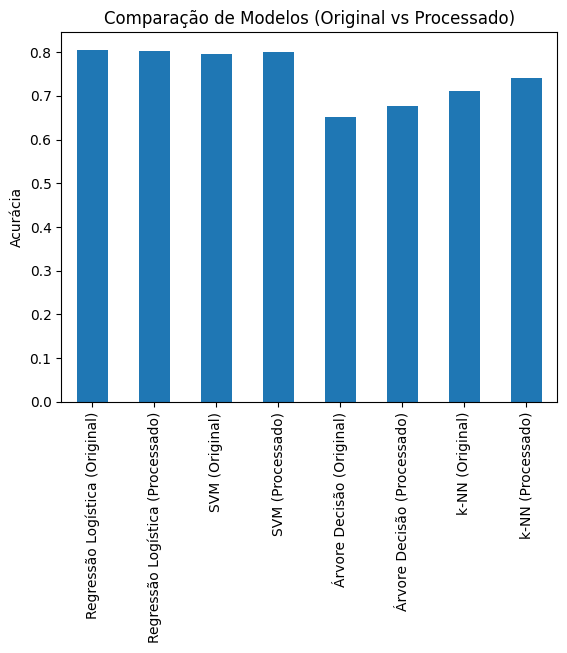

In [12]:
# Upload do Word2Vec pré-treinado
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model, size=300):
        self.model = model
        self.size = size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def get_vector(text):
            words = text.split()
            word_vecs = [self.model[word] for word in words if word in self.model]
         
            if len(word_vecs) == 0:
                return np.zeros(self.size)
            return np.mean(word_vecs, axis=0)

        return np.array([get_vector(text) for text in X])

# Word2VecVectorizer
word2vec_vectorizer = Word2VecVectorizer(model=word2vec_model)

# Modelos com Word2Vec
lr_model_w2v = Pipeline([
    ('w2v', word2vec_vectorizer),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, solver='saga'))
])

svm_model_w2v = Pipeline([
    ('w2v', word2vec_vectorizer),
    ('clf', LinearSVC(
        class_weight='balanced',
        dual=False,
        max_iter=10000,
        C=0.5,
        loss='squared_hinge'
    ))
])

dt_model_w2v = Pipeline([
    ('w2v', word2vec_vectorizer),
    ('clf', DecisionTreeClassifier(
        max_depth=50,
        min_samples_split=20,
        class_weight='balanced',
        random_state=123
    ))
])

knn_model_w2v = Pipeline([
    ('w2v', word2vec_vectorizer),
    ('clf', KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        metric='cosine'
    ))
])

#Original sem pré processamento
print("\n=== Regressão Logística com Word2Vec (Original) ===")
lr_trained_w2v_original = train_evaluate(lr_model_w2v, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== SVM (Original) ===")
svm_trained_w2v_original = train_evaluate(svm_model_w2v, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Árvore de Decisão (Original) ===")
dt_trained_w2v_original = train_evaluate(dt_model_w2v, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== k-NN (Original) ===")
knn_trained_w2v_original = train_evaluate(knn_model_w2v, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])

#Original com pré-processamento
print("\n=== Regressão Logística com Word2Vec (Processado) ===")
lr_trained_w2v_processed = train_evaluate(lr_model_w2v, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== SVM (Processado) ===")
svm_trained_w2v_processed = train_evaluate(svm_model_w2v, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Árvore de Decisão (Processado) ===")
dt_trained_w2v_processed = train_evaluate(dt_model_w2v, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== k-NN (Processado) ===")
knn_trained_w2v_processed = train_evaluate(knn_model_w2v, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])

# Análise comparativa
results_W2V = {

    'Regressão Logística (Original)': accuracy_score(test_df['sentiment'], lr_trained_w2v_original.predict(test_df['review'])),
    'Regressão Logística (Processado)': accuracy_score(test_df['sentiment'], lr_trained_w2v_processed.predict(test_processed)),
    'SVM (Original)': accuracy_score(test_df['sentiment'], svm_trained_w2v_original.predict(test_df['review'])),
    'SVM (Processado)': accuracy_score(test_df['sentiment'], svm_trained_w2v_processed.predict(test_processed)),
    'Árvore Decisão (Original)': accuracy_score(test_df['sentiment'], dt_trained_w2v_original.predict(test_df['review'])),
    'Árvore Decisão (Processado)': accuracy_score(test_df['sentiment'], dt_trained_w2v_processed.predict(test_processed)),
    'k-NN (Original)': accuracy_score(test_df['sentiment'], knn_trained_w2v_original.predict(test_df['review'])),
    'k-NN (Processado)': accuracy_score(test_df['sentiment'], knn_trained_w2v_processed.predict(test_processed))
}

# Gráfico comparativo
pd.Series(results_W2V).plot(kind='bar', title='Comparação de Modelos (Original vs Processado)')
pd.Series(results_W2V).plot(kind='bar', title='Comparação de Modelos (Original vs Processado)')
plt.ylabel('Acurácia')
plt.show()


Modelos Clássicos com Word2Vec com oversampling


=== Regressão Logística com Word2Vec + SMOTE (Original) ===
Acurácia: 0.7977
              precision    recall  f1-score   support

    negative       0.63      0.82      0.71       741
    positive       0.91      0.79      0.84      1676

    accuracy                           0.80      2417
   macro avg       0.77      0.80      0.78      2417
weighted avg       0.82      0.80      0.80      2417


=== SVM com Word2Vec + SMOTE (Original) ===
Acurácia: 0.8010
              precision    recall  f1-score   support

    negative       0.64      0.81      0.71       741
    positive       0.90      0.80      0.85      1676

    accuracy                           0.80      2417
   macro avg       0.77      0.80      0.78      2417
weighted avg       0.82      0.80      0.81      2417


=== Árvore de Decisão com Word2Vec + SMOTE (Original) ===
Acurácia: 0.6727
              precision    recall  f1-score   support

    negative       0.47      0.49      0.48       741
    positive       0.

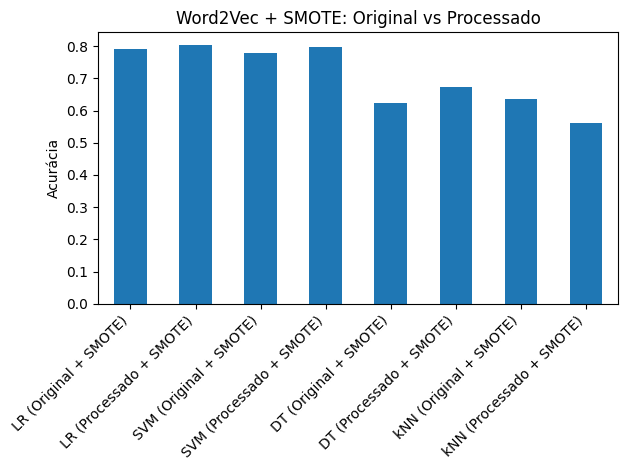

In [13]:
from imblearn.pipeline import Pipeline as ImbPipeline
# Pipeline com Word2Vec e SMOTE
lr_model_w2v_smote = ImbPipeline([
    ('w2v', word2vec_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, solver='saga'))
])

svm_model_w2v_smote = ImbPipeline([
    ('w2v', word2vec_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=0.5, loss='squared_hinge'))
])

dt_model_w2v_smote = ImbPipeline([
    ('w2v', word2vec_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(max_depth=50, min_samples_split=20, class_weight='balanced', random_state=123))
])

knn_model_w2v_smote = ImbPipeline([
    ('w2v', word2vec_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))
])

# Versão Original com SMOTE
print("\n=== Regressão Logística com Word2Vec + SMOTE (Original) ===")
lr_w2v_smote_original = train_evaluate(lr_model_w2v_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== SVM com Word2Vec + SMOTE (Original) ===")
svm_w2v_smote_original = train_evaluate(svm_model_w2v_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Árvore de Decisão com Word2Vec + SMOTE (Original) ===")
dt_w2v_smote_original = train_evaluate(dt_model_w2v_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== k-NN com Word2Vec + SMOTE (Original) ===")
knn_w2v_smote_original = train_evaluate(knn_model_w2v_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])

# Versão Processada com SMOTE
print("\n=== Regressão Logística com Word2Vec + SMOTE (Processado) ===")
lr_w2v_smote_processed = train_evaluate(lr_model_w2v_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== SVM com Word2Vec + SMOTE (Processado) ===")
svm_w2v_smote_processed = train_evaluate(svm_model_w2v_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Árvore de Decisão com Word2Vec + SMOTE (Processado) ===")
dt_w2v_smote_processed = train_evaluate(dt_model_w2v_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== k-NN com Word2Vec + SMOTE (Processado) ===")
knn_w2v_smote_processed = train_evaluate(knn_model_w2v_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])


results_W2V_SMOTE = {
    'LR (Original + SMOTE)': accuracy_score(test_df['sentiment'], lr_w2v_smote_original.predict(test_df['review'])),
    'LR (Processado + SMOTE)': accuracy_score(test_df['sentiment'], lr_w2v_smote_processed.predict(test_processed)),
    'SVM (Original + SMOTE)': accuracy_score(test_df['sentiment'], svm_w2v_smote_original.predict(test_df['review'])),
    'SVM (Processado + SMOTE)': accuracy_score(test_df['sentiment'], svm_w2v_smote_processed.predict(test_processed)),
    'DT (Original + SMOTE)': accuracy_score(test_df['sentiment'], dt_w2v_smote_original.predict(test_df['review'])),
    'DT (Processado + SMOTE)': accuracy_score(test_df['sentiment'], dt_w2v_smote_processed.predict(test_processed)),
    'kNN (Original + SMOTE)': accuracy_score(test_df['sentiment'], knn_w2v_smote_original.predict(test_df['review'])),
    'kNN (Processado + SMOTE)': accuracy_score(test_df['sentiment'], knn_w2v_smote_processed.predict(test_processed))
}

pd.Series(results_W2V_SMOTE).plot(kind='bar', title='Word2Vec + SMOTE: Original vs Processado')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Modelos Clássicos com Glove sem oversampling


=== Regressão Logística com GloVe (Original) ===
Acurácia: 0.7766
              precision    recall  f1-score   support

    negative       0.60      0.80      0.69       741
    positive       0.90      0.77      0.83      1676

    accuracy                           0.78      2417
   macro avg       0.75      0.78      0.76      2417
weighted avg       0.81      0.78      0.78      2417


=== SVM (Original) ===
Acurácia: 0.7716
              precision    recall  f1-score   support

    negative       0.60      0.80      0.68       741
    positive       0.89      0.76      0.82      1676

    accuracy                           0.77      2417
   macro avg       0.74      0.78      0.75      2417
weighted avg       0.80      0.77      0.78      2417


=== Árvore de Decisão (Original) ===
Acurácia: 0.6682
              precision    recall  f1-score   support

    negative       0.46      0.43      0.44       741
    positive       0.75      0.77      0.76      1676

    accuracy       

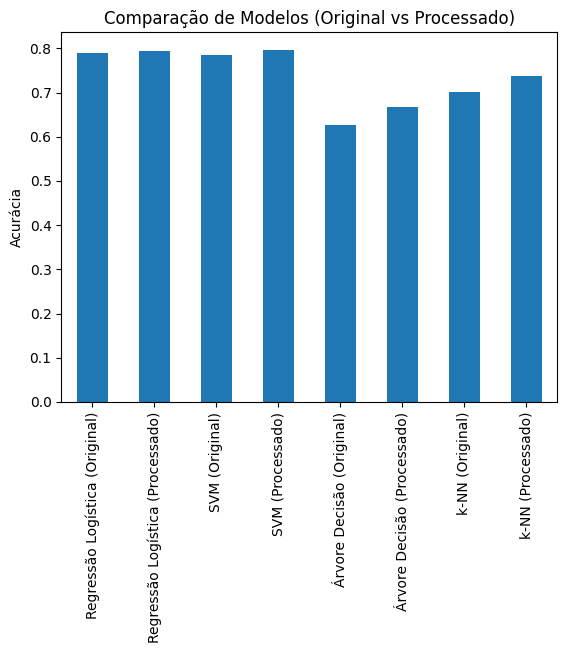

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline 
# Função de upload do modelo glove
def load_glove_model(file_path):
    model = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            model[word] = vector
    return model

# Carregar o modelo GloVe (substitua o caminho pelo seu arquivo)
glove_model = load_glove_model('glove.twitter.27B.200d.txt')

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model, size=200):
        self.model = model
        self.size = size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def get_vector(text):
            words = text.split()
            word_vecs = [self.model[word] for word in words if word in self.model]
            if len(word_vecs) == 0:
                return np.zeros(self.size)
            return np.mean(word_vecs, axis=0)

        return np.array([get_vector(text) for text in X])

# Usar GloVe como substituto para o TfidfVectorizer
glove_vectorizer = GloVeVectorizer(model=glove_model)

# Modelos usando GloVe
lr_model_glove = Pipeline([
    ('glove', glove_vectorizer),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, solver='saga'))
])

svm_model_glove = Pipeline([
    ('glove', glove_vectorizer),
    ('clf', LinearSVC(
        class_weight='balanced',
        dual=False,
        max_iter=10000,
        C=0.5,
        loss='squared_hinge'
    ))
])

dt_model_glove = Pipeline([
    ('glove', glove_vectorizer),
    ('clf', DecisionTreeClassifier(
        max_depth=50,
        min_samples_split=20,
        class_weight='balanced',
        random_state=123
    ))
])

knn_model_glove = Pipeline([
    ('glove', glove_vectorizer),
    ('clf', KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        metric='cosine'
    ))
])

# Execução para cada modelo com o dataset original (sem processamento)
print("\n=== Regressão Logística com GloVe (Original) ===")
lr_trained_glove_original = train_evaluate(lr_model_glove, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== SVM (Original) ===")
svm_trained_glove_original = train_evaluate(svm_model_glove, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Árvore de Decisão (Original) ===")
dt_trained_glove_original = train_evaluate(dt_model_glove, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== k-NN (Original) ===")
knn_trained_glove_original = train_evaluate(knn_model_glove, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])

# Execução para cada modelo com o dataset processado
print("\n=== Regressão Logística com GloVe (Processado) ===")
lr_trained_glove_processed = train_evaluate(lr_model_glove, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== SVM (Processado) ===")
svm_trained_glove_processed = train_evaluate(svm_model_glove, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Árvore de Decisão (Processado) ===")
dt_trained_glove_processed = train_evaluate(dt_model_glove, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== k-NN (Processado) ===")
knn_trained_glove_processed = train_evaluate(knn_model_glove, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])

# Análise comparativa
results_Glove = {
    'Regressão Logística (Original)': accuracy_score(test_df['sentiment'], lr_trained_glove_original.predict(test_df['review'])),
    'Regressão Logística (Processado)': accuracy_score(test_df['sentiment'], lr_trained_glove_processed.predict(test_processed)),
    'SVM (Original)': accuracy_score(test_df['sentiment'], svm_trained_glove_original.predict(test_df['review'])),
    'SVM (Processado)': accuracy_score(test_df['sentiment'], svm_trained_glove_processed.predict(test_processed)),
    'Árvore Decisão (Original)': accuracy_score(test_df['sentiment'], dt_trained_glove_original.predict(test_df['review'])),
    'Árvore Decisão (Processado)': accuracy_score(test_df['sentiment'], dt_trained_glove_processed.predict(test_processed)),
    'k-NN (Original)': accuracy_score(test_df['sentiment'], knn_trained_glove_original.predict(test_df['review'])),
    'k-NN (Processado)': accuracy_score(test_df['sentiment'], knn_trained_glove_processed.predict(test_processed))
}

# Gráfico comparativo entre os modelos
pd.Series(results_Glove).plot(kind='bar', title='Comparação de Modelos (Original vs Processado)')
pd.Series(results_Glove).plot(kind='bar', title='Comparação de Modelos (Original vs Processado)')
plt.ylabel('Acurácia')
plt.show()

Modelos Clássicos com Glove sem oversampling


=== Regressão Logística com GloVe + SMOTE (Original) ===
Acurácia: 0.7770
              precision    recall  f1-score   support

    negative       0.61      0.78      0.68       741
    positive       0.89      0.78      0.83      1676

    accuracy                           0.78      2417
   macro avg       0.75      0.78      0.76      2417
weighted avg       0.80      0.78      0.78      2417


=== SVM com GloVe + SMOTE (Original) ===
Acurácia: 0.7741
              precision    recall  f1-score   support

    negative       0.60      0.78      0.68       741
    positive       0.89      0.77      0.83      1676

    accuracy                           0.77      2417
   macro avg       0.74      0.78      0.75      2417
weighted avg       0.80      0.77      0.78      2417


=== Árvore de Decisão com GloVe + SMOTE (Original) ===
Acurácia: 0.6537
              precision    recall  f1-score   support

    negative       0.44      0.49      0.47       741
    positive       0.76      0

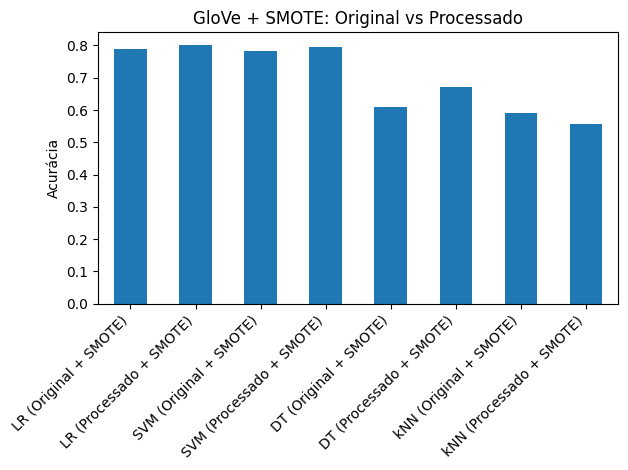

In [15]:
# Pipelines com GloVe e SMOTE
lr_model_glove_smote = ImbPipeline([
    ('glove', glove_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, solver='saga'))
])

svm_model_glove_smote = ImbPipeline([
    ('glove', glove_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=0.5, loss='squared_hinge'))
])

dt_model_glove_smote = ImbPipeline([
    ('glove', glove_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(max_depth=50, min_samples_split=20, class_weight='balanced', random_state=123))
])

knn_model_glove_smote = ImbPipeline([
    ('glove', glove_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))
])

# Versão Original + SMOTE
print("\n=== Regressão Logística com GloVe + SMOTE (Original) ===")
lr_glove_smote_original = train_evaluate(lr_model_glove_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== SVM com GloVe + SMOTE (Original) ===")
svm_glove_smote_original = train_evaluate(svm_model_glove_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Árvore de Decisão com GloVe + SMOTE (Original) ===")
dt_glove_smote_original = train_evaluate(dt_model_glove_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== k-NN com GloVe + SMOTE (Original) ===")
knn_glove_smote_original = train_evaluate(knn_model_glove_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])

# Versão Processada + SMOTE
print("\n=== Regressão Logística com GloVe + SMOTE (Processado) ===")
lr_glove_smote_processed = train_evaluate(lr_model_glove_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== SVM com GloVe + SMOTE (Processado) ===")
svm_glove_smote_processed = train_evaluate(svm_model_glove_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Árvore de Decisão com GloVe + SMOTE (Processado) ===")
dt_glove_smote_processed = train_evaluate(dt_model_glove_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== k-NN com GloVe + SMOTE (Processado) ===")
knn_glove_smote_processed = train_evaluate(knn_model_glove_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])

results_Glove_SMOTE = {
    'LR (Original + SMOTE)': accuracy_score(test_df['sentiment'], lr_glove_smote_original.predict(test_df['review'])),
    'LR (Processado + SMOTE)': accuracy_score(test_df['sentiment'], lr_glove_smote_processed.predict(test_processed)),
    'SVM (Original + SMOTE)': accuracy_score(test_df['sentiment'], svm_glove_smote_original.predict(test_df['review'])),
    'SVM (Processado + SMOTE)': accuracy_score(test_df['sentiment'], svm_glove_smote_processed.predict(test_processed)),
    'DT (Original + SMOTE)': accuracy_score(test_df['sentiment'], dt_glove_smote_original.predict(test_df['review'])),
    'DT (Processado + SMOTE)': accuracy_score(test_df['sentiment'], dt_glove_smote_processed.predict(test_processed)),
    'kNN (Original + SMOTE)': accuracy_score(test_df['sentiment'], knn_glove_smote_original.predict(test_df['review'])),
    'kNN (Processado + SMOTE)': accuracy_score(test_df['sentiment'], knn_glove_smote_processed.predict(test_processed))
}

pd.Series(results_Glove_SMOTE).plot(kind='bar', title='GloVe + SMOTE: Original vs Processado')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Bag of Words

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Bag of Words Vectorizer
bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')

# Modelos sem SMOTE
nb_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', MultinomialNB(alpha=0.1))
])

lr_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, solver='saga'))
])

svm_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=0.5, loss='squared_hinge'))
])

dt_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', DecisionTreeClassifier(max_depth=50, min_samples_split=20, class_weight='balanced', random_state=123))
])

knn_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))
])

def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    return model

# Treino e avaliação
print("=== Naïve Bayes (BoW - Original) ===")
nb_trained_original = train_evaluate(nb_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Regressão Logística (BoW - Original) ===")
lr_trained_original = train_evaluate(lr_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== SVM (BoW - Original) ===")
svm_trained_original = train_evaluate(svm_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Árvore de Decisão (BoW - Original) ===")
dt_trained_original = train_evaluate(dt_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== k-NN (BoW - Original) ===")
knn_trained_original = train_evaluate(knn_model, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])


print("\n\n=== Modelos com SMOTE ===")
# Bag of Words Vectorizer para SMOTE
bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')

nb_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', MultinomialNB(alpha=0.1))
])

lr_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, solver='saga'))
])

svm_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=0.5, loss='squared_hinge'))
])

dt_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(max_depth=50, min_samples_split=20, class_weight='balanced', random_state=123))
])

knn_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))
])

# Treino e avaliação com SMOTE
print("=== Naïve Bayes (BoW + SMOTE) ===")
nb_trained_smote = train_evaluate(nb_model_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Regressão Logística (BoW + SMOTE) ===")
lr_trained_smote = train_evaluate(lr_model_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== SVM (BoW + SMOTE) ===")
svm_trained_smote = train_evaluate(svm_model_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== Árvore de Decisão (BoW + SMOTE) ===")
dt_trained_smote = train_evaluate(dt_model_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])
print("\n=== k-NN (BoW + SMOTE) ===")
knn_trained_smote = train_evaluate(knn_model_smote, train_df['review'], train_df['sentiment'], test_df['review'], test_df['sentiment'])


=== Naïve Bayes (BoW - Original) ===
Acurácia: 0.8639
              precision    recall  f1-score   support

    negative       0.77      0.80      0.78       741
    positive       0.91      0.89      0.90      1676

    accuracy                           0.86      2417
   macro avg       0.84      0.85      0.84      2417
weighted avg       0.87      0.86      0.86      2417


=== Regressão Logística (BoW - Original) ===


c:\Users\Carolina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Acurácia: 0.8593
              precision    recall  f1-score   support

    negative       0.75      0.81      0.78       741
    positive       0.91      0.88      0.90      1676

    accuracy                           0.86      2417
   macro avg       0.83      0.85      0.84      2417
weighted avg       0.86      0.86      0.86      2417


=== SVM (BoW - Original) ===
Acurácia: 0.8366
              precision    recall  f1-score   support

    negative       0.72      0.76      0.74       741
    positive       0.89      0.87      0.88      1676

    accuracy                           0.84      2417
   macro avg       0.81      0.82      0.81      2417
weighted avg       0.84      0.84      0.84      2417


=== Árvore de Decisão (BoW - Original) ===
Acurácia: 0.7464
              precision    recall  f1-score   support

    negative       0.57      0.72      0.63       741
    positive       0.86      0.76      0.81      1676

    accuracy                           0.75      2417
   

c:\Users\Carolina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Acurácia: 0.8341
              precision    recall  f1-score   support

    negative       0.72      0.76      0.74       741
    positive       0.89      0.87      0.88      1676

    accuracy                           0.83      2417
   macro avg       0.80      0.81      0.81      2417
weighted avg       0.84      0.83      0.84      2417


=== SVM (BoW + SMOTE) ===
Acurácia: 0.8204
              precision    recall  f1-score   support

    negative       0.70      0.72      0.71       741
    positive       0.87      0.87      0.87      1676

    accuracy                           0.82      2417
   macro avg       0.79      0.79      0.79      2417
weighted avg       0.82      0.82      0.82      2417


=== Árvore de Decisão (BoW + SMOTE) ===
Acurácia: 0.7456
              precision    recall  f1-score   support

    negative       0.58      0.59      0.59       741
    positive       0.82      0.81      0.82      1676

    accuracy                           0.75      2417
   macro 

=== Naïve Bayes (BoW - Processado) ===
Acurácia: 0.8643
              precision    recall  f1-score   support

    negative       0.76      0.82      0.79       741
    positive       0.92      0.88      0.90      1676

    accuracy                           0.86      2417
   macro avg       0.84      0.85      0.84      2417
weighted avg       0.87      0.86      0.87      2417


=== Regressão Logística (BoW - Processado) ===
Acurácia: 0.8672
              precision    recall  f1-score   support

    negative       0.77      0.81      0.79       741
    positive       0.91      0.89      0.90      1676

    accuracy                           0.87      2417
   macro avg       0.84      0.85      0.85      2417
weighted avg       0.87      0.87      0.87      2417


=== SVM (BoW - Processado) ===
Acurácia: 0.8531
              precision    recall  f1-score   support

    negative       0.76      0.76      0.76       741
    positive       0.89      0.89      0.89      1676

    accuracy

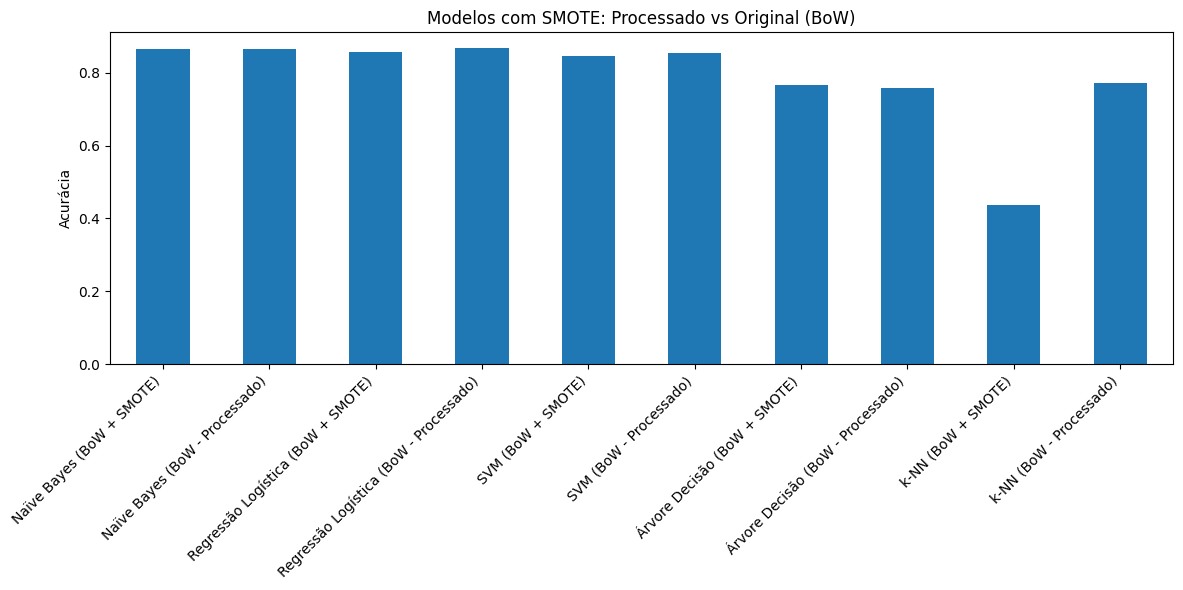

In [18]:
# Bag of Words Vectorizer
bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')

# Modelos sem SMOTE
nb_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', MultinomialNB(alpha=0.1))
])

lr_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, solver='saga'))
])

svm_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=0.5, loss='squared_hinge'))
])

dt_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', DecisionTreeClassifier(max_depth=50, min_samples_split=20, class_weight='balanced', random_state=123))
])

knn_model = Pipeline([
    ('bow', bow_vectorizer),
    ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))
])

# Função de treino e avaliação
def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    return model

# Treino e avaliação com dados processados (sem SMOTE)
print("=== Naïve Bayes (BoW - Processado) ===")
nb_trained_processed = train_evaluate(nb_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Regressão Logística (BoW - Processado) ===")
lr_trained_processed = train_evaluate(lr_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== SVM (BoW - Processado) ===")
svm_trained_processed = train_evaluate(svm_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Árvore de Decisão (BoW - Processado) ===")
dt_trained_processed = train_evaluate(dt_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== k-NN (BoW - Processado) ===")
knn_trained_processed = train_evaluate(knn_model, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])


print("\n\n=== Modelos com SMOTE ===")
# Modelos com SMOTE
nb_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', MultinomialNB(alpha=0.1))
])

lr_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, solver='saga'))
])

svm_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(class_weight='balanced', dual=False, max_iter=10000, C=0.5, loss='squared_hinge'))
])

dt_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(max_depth=50, min_samples_split=20, class_weight='balanced', random_state=123))
])

knn_model_smote = Pipeline([
    ('bow', bow_vectorizer),
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine'))
])

# Treino e avaliação com SMOTE
print("=== Naïve Bayes (BoW + SMOTE) ===")
nb_trained_smote = train_evaluate(nb_model_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Regressão Logística (BoW + SMOTE) ===")
lr_trained_smote = train_evaluate(lr_model_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== SVM (BoW + SMOTE) ===")
svm_trained_smote = train_evaluate(svm_model_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== Árvore de Decisão (BoW + SMOTE) ===")
dt_trained_smote = train_evaluate(dt_model_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])
print("\n=== k-NN (BoW + SMOTE) ===")
knn_trained_smote = train_evaluate(knn_model_smote, train_processed, train_df['sentiment'], test_processed, test_df['sentiment'])

# Comparativo de resultados
results_comparativo = {
    'Naïve Bayes (BoW + SMOTE)': accuracy_score(test_df['sentiment'], nb_trained_smote.predict(test_processed)),
    'Naïve Bayes (BoW - Processado)': accuracy_score(test_df['sentiment'], nb_trained_processed.predict(test_processed)),

    'Regressão Logística (BoW + SMOTE)': accuracy_score(test_df['sentiment'], lr_trained_smote.predict(test_processed)),
    'Regressão Logística (BoW - Processado)': accuracy_score(test_df['sentiment'], lr_trained_processed.predict(test_processed)),

    'SVM (BoW + SMOTE)': accuracy_score(test_df['sentiment'], svm_trained_smote.predict(test_processed)),
    'SVM (BoW - Processado)': accuracy_score(test_df['sentiment'], svm_trained_processed.predict(test_processed)),

    'Árvore Decisão (BoW + SMOTE)': accuracy_score(test_df['sentiment'], dt_trained_smote.predict(test_processed)),
    'Árvore Decisão (BoW - Processado)': accuracy_score(test_df['sentiment'], dt_trained_processed.predict(test_processed)),

    'k-NN (BoW + SMOTE)': accuracy_score(test_df['sentiment'], knn_trained_smote.predict(test_processed)),
    'k-NN (BoW - Processado)': accuracy_score(test_df['sentiment'], knn_trained_processed.predict(test_processed)),
}

# Gráfico de comparação
pd.Series(results_comparativo).plot(kind='bar', title='Modelos com SMOTE: Processado vs Original (BoW)', figsize=(12, 6))
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Modelo final com os melhores parametros, processamento, sampling

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Pipeline com todos os hiperparâmetros encontrados
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='word',
        binary=False,
        decode_error='strict',
        dtype='float64',
        encoding='utf-8',
        input='content',
        lowercase=True,
        max_df=1.0,
        max_features=10000,
        min_df=1,
        ngram_range=(1, 2),
        norm='l2',
        preprocessor=None,
        smooth_idf=True,
        stop_words='english',
        strip_accents=None,
        sublinear_tf=False,
        token_pattern=r'(?u)\b\w\w+\b',
        tokenizer=None,
        use_idf=True,
        vocabulary=None
    )),
    ('smote', SMOTE(
        k_neighbors=5,
        random_state=42,
        sampling_strategy='auto'
    )),
    ('clf', LinearSVC(
        C=0.1,
        class_weight='balanced',
        dual=True,
        fit_intercept=True,
        intercept_scaling=1,
        loss='squared_hinge',
        max_iter=10000,
        multi_class='ovr',
        penalty='l2',
        random_state=None,
        tol=0.0001,
        verbose=0
    ))
])


In [28]:

final_pipeline.fit(train_processed, train_df['sentiment'])
y_pred = final_pipeline.predict(test_processed)

from sklearn.metrics import accuracy_score, classification_report
print(f"Acurácia final: {accuracy_score(test_df['sentiment'], y_pred):.4f}")
print(classification_report(test_df['sentiment'], y_pred))


c:\Users\Carolina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:2043: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float64 'dtype' will be converted to np.float64.
  warnings.warn(


Acurácia final: 0.8833
              precision    recall  f1-score   support

    negative       0.78      0.86      0.82       741
    positive       0.94      0.89      0.91      1676

    accuracy                           0.88      2417
   macro avg       0.86      0.88      0.87      2417
weighted avg       0.89      0.88      0.88      2417



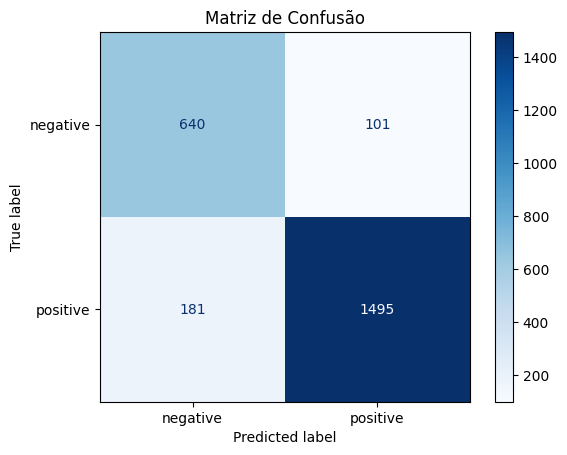

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Gerar a matriz de confusão
cm = confusion_matrix(test_df['sentiment'], y_pred)

# Mostrar a matriz de confusão de forma gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão')
plt.show()
